In [76]:
import os
import numpy as np
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices("GPU") else "NOT AVAILABLE")


Version:  2.11.0
Eager mode:  True
Hub version:  0.12.0
GPU is NOT AVAILABLE


In [77]:
# Split the training set into 60% and 40% to end up with 15,000 examples
# for training, 10,000 examples for validation and 25,000 examples for testing.
train_data, validation_data, test_data = tfds.load(
    name="imdb_reviews", 
    split=('train[:60%]', 'train[60%:]', 'test'),
    as_supervised=True)


In [78]:
train_examples_batch, train_labels_batch = next(iter(train_data.batch(10)))
train_examples_batch.shape , train_labels_batch.shape

2023-01-05 13:46:36.096956: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


(TensorShape([10]), TensorShape([10]))

In [79]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, input_shape=[], 
                           dtype=tf.string, trainable=True)
hub_layer(train_examples_batch[:3])


<tf.Tensor: shape=(3, 50), dtype=float32, numpy=
array([[ 0.5423195 , -0.0119017 ,  0.06337538,  0.06862972, -0.16776837,
        -0.10581174,  0.16865303, -0.04998824, -0.31148055,  0.07910346,
         0.15442263,  0.01488662,  0.03930153,  0.19772711, -0.12215476,
        -0.04120981, -0.2704109 , -0.21922152,  0.26517662, -0.80739075,
         0.25833532, -0.3100421 ,  0.28683215,  0.1943387 , -0.29036492,
         0.03862849, -0.7844411 , -0.0479324 ,  0.4110299 , -0.36388892,
        -0.58034706,  0.30269456,  0.3630897 , -0.15227164, -0.44391504,
         0.19462997,  0.19528408,  0.05666234,  0.2890704 , -0.28468323,
        -0.00531206,  0.0571938 , -0.3201318 , -0.04418665, -0.08550783,
        -0.55847436, -0.23336391, -0.20782952, -0.03543064, -0.17533456],
       [ 0.56338924, -0.12339553, -0.10862679,  0.7753425 , -0.07667089,
        -0.15752277,  0.01872335, -0.08169781, -0.3521876 ,  0.4637341 ,
        -0.08492756,  0.07166859, -0.00670817,  0.12686075, -0.19326553,
 

In [80]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(10, activation='relu'))
model.add(tf.keras.layers.Dense(1,))

model.summary()

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_data.shuffle(10000).batch(512),
                    epochs=10,
                    validation_data=validation_data.batch(512),
                    verbose=1)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 50)                48190600  
                                                                 
 dense_11 (Dense)            (None, 10)                510       
                                                                 
 dense_12 (Dense)            (None, 1)                 11        
                                                                 
Total params: 48,191,121
Trainable params: 48,191,121
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
30/30 [==============================] - 19s 603ms/step - loss: 0.6965 - accuracy: 0.5166 - val_loss: 0.6304 - val_accuracy: 0.5588
Epoch 2/10
30/30 [==============================] - 17s 578ms/step - loss: 0.5787 - accuracy: 0.6383 - val_loss: 0.5539 - val_accuracy: 0.6789
Epoch 3/10
30/30 [==

In [81]:
results = model.evaluate(test_data.batch(512), verbose=2)


49/49 - 3s - loss: 0.3357 - accuracy: 0.8519 - 3s/epoch - 62ms/step


Prepare input dataset

In [82]:
def get_features_from_tfdataset(tfdataset, batched=False):

    features = list(map(lambda x: x[0], tfdataset)) # Get labels 

    if not batched:
        return tf.stack(features, axis=0)
    return features


def get_labels_from_tfdataset(tfdataset, batched=False):

    labels = list(map(lambda x: x[1], tfdataset)) # Get labels 

    if not batched:
        return tf.stack(labels, axis=0)

    return labels

In [83]:
labels = get_labels_from_tfdataset(train_data)
features = get_features_from_tfdataset(train_data)
labels.shape, features.shape , features.ndim

(TensorShape([15000]), TensorShape([15000]), 1)

In [84]:
test_feature = get_features_from_tfdataset(test_data)
test_labels = get_labels_from_tfdataset(test_data)
test_feature.shape, test_labels.shape

(TensorShape([25000]), TensorShape([25000]))

In [85]:
valid_features = get_features_from_tfdataset(validation_data)
valid_label = get_labels_from_tfdataset(validation_data)
valid_features.shape, valid_label.shape

(TensorShape([10000]), TensorShape([10000]))

In [86]:
result_preds_probs = model.predict(valid_features)
result_preds_probs

313/313 [==============================] - 15s 48ms/step


array([[ 1.3208473 ],
       [ 0.5171427 ],
       [ 4.4492545 ],
       ...,
       [-8.56695   ],
       [ 2.4473455 ],
       [ 0.49425808]], dtype=float32)

In [130]:
result_preds_probs.shape , valid_label.shape

((10000, 1), TensorShape([10000]))

In [87]:
result_preds = tf.squeeze(tf.round(result_preds_probs))
result_preds

<tf.Tensor: shape=(10000,), dtype=float32, numpy=array([ 1.,  1.,  4., ..., -9.,  2.,  0.], dtype=float32)>

In [88]:
def calculate_accuracy_results(y_true, y_pred):
    from sklearn.metrics import accuracy_score, precision_recall_fscore_support
    # Calculate model accuracy
    model_accuracy = accuracy_score(y_true, y_pred) * 100
    # Calculate model precision, recall and f1 score using "weighted average
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted", zero_division= 1)
    model_results = {"accuracy": model_accuracy,
                      "precision": model_precision,
                      "recall": model_recall,
                      "f1": model_f1}
    return model_results

In [127]:
results = calculate_accuracy_results( 
    y_true= valid_label,
    y_pred = result_preds)
results

{'accuracy': 8.3,
 'precision': 0.5918972273929656,
 'recall': 0.083,
 'f1': 0.1455836900312579}

Test with another methods. Building own tokenized layers and embedding layers

In [90]:
# How long is each sentence on average?
sent_lens = [len(sentence.split()) for sentence in features.numpy()]
avg_sent_len = np.mean(sent_lens)
avg_sent_len # return average sentence length (in tokens)

233.5422

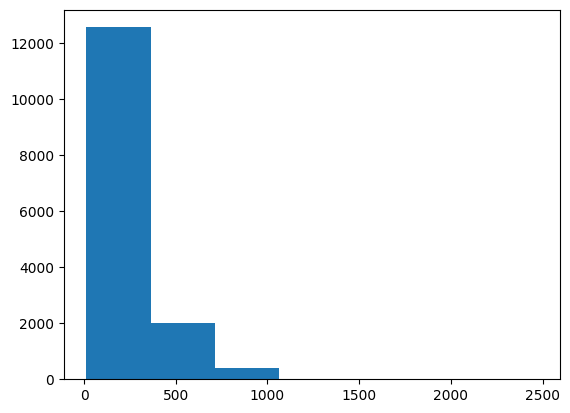

In [91]:
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=7);

In [92]:
# How long of a sentence covers 95% of the lengths?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

599

In [93]:
features[1].numpy() ,features[1]

(b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. The plot development was constant. Constantly slow and boring. Things seemed to happen, but with no explanation of what was causing them or why. I admit, I may have missed part of the film, but i watched the majority of it and everything just seemed to happen of its own accord without any real concern for anything else. I cant recommend this film at all.',
 <tf.Tensor: shape=(), dtype=string, numpy=b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. The plot development was constant. Constantly slow and boring. Things s

In [94]:
from tensorflow.keras import layers

max_vocab = 5000  # Maximum vocab size.
max_seq_len = 600  # Sequence length to pad the outputs to.

# Create the layer.
vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=max_vocab,
    output_mode='int',
    output_sequence_length=max_seq_len)

# Now that the vocab layer has been created, call `adapt` on the
# text-only dataset to create the vocabulary. You don't have to batch,
# but for large datasets this means we're not keeping spare copies of
# the dataset.
vectorize_layer.adapt(features)

embedding_layers = layers.Embedding(input_dim=max_vocab,
                                     output_dim=5,
                                     embeddings_initializer="uniform",
                                     input_length = max_seq_len,
                                     name="embedding_layers")


In [95]:
import random
random_sentence = random.choice(features)
print(f"Original text:\n{random_sentence}\
      \n\nVectorized version:")
vectorize_layer([random_sentence])

Original text:
b'This is one of my favorites along with the Mariette Hartley and Robert Lansing "Sandy" and the Agnes Moorhead-and-the-tiny-spacemen episodes.<br /><br />It is an important take, from mid-1961, on the long Cold War that the U.S. was then embroiled in. The beaten-down city-scene, the near-starving characters\' sparse dialog, their threadbare uniforms, and the minimal action "says" it all: the absurdity of an on-going conflict that threatens to destroy human life, modern civilization, and all that is sweet and redeeming about it.<br /><br />It is a "fable" because it was made in a time in which, had events turned out differently, such as the second Berlin Crisis (Spring 1961) and the subsequent Cuban Missile Crisis (Oct. 1962), it would have actually been a reasonable representation of one of the U.S.\'s major cities, ruined and replete with a few miserable survivors. I also see it as a "fable" because it is not only a cautionary tale, but because it is the most redemptiv

<tf.Tensor: shape=(1, 600), dtype=int64, numpy=
array([[  11,    7,   29,    5,   54, 2526,  354,   17,    2,    1,    1,
           3,  655,    1,    1,    3,    2,    1,    1,    1,   13,    9,
           7,   34,  671,  186,   36,    1,   21,    2,  204, 1083,  332,
          12,    2,  170,   14,   91,    1,    8,    2,    1,    1,    2,
           1,  103,    1,  779,   66,    1,    1,    3,    2, 3883,  218,
         526,    9,   32,    2,    1,    5,   34,    1, 1964,   12,    1,
           6, 2240,  402,  118,  732, 4169,    3,   32,   12,    7, 1071,
           3, 1505,   43,  597,   13,    9,    7,    4,    1,   81,    9,
          14,   93,    8,    4,   60,    8,   62,   65,  653,  662,   46,
           1,  136,   15,    2,  320,    1, 3574, 3177,    1,    3,    2,
        3800,    1,    1, 3574,    1,    1,    9,   56,   26,  155,   75,
           4, 3806,    1,    5,   29,    5,    2,    1,  659,    1, 2127,
           3,    1,   17,    4,  167, 4365, 4247,   10,   76,   

In [96]:
test = vectorize_layer(features)
test

<tf.Tensor: shape=(15000, 600), dtype=int64, numpy=
array([[  11,   14,   34, ...,    0,    0,    0],
       [  10,   26,   75, ...,    0,    0,    0],
       [3814,    1,    2, ...,    0,    0,    0],
       ...,
       [  10,  205,   11, ...,    0,    0,    0],
       [  95, 2925,    1, ...,    0,    0,    0],
       [ 204,  352,    1, ...,    0,    0,    0]])>

In [97]:
test_emb = embedding_layers(test)
test_emb

<tf.Tensor: shape=(15000, 600, 5), dtype=float32, numpy=
array([[[ 4.09096517e-02,  3.17290910e-02, -2.70222072e-02,
         -4.17363867e-02,  1.75849460e-02],
        [ 1.38682835e-02,  1.70120858e-02,  2.52556466e-02,
          3.44460346e-02,  3.82332094e-02],
        [-2.66459230e-02,  3.96789238e-03,  2.98628099e-02,
          2.27715708e-02, -6.71520829e-05],
        ...,
        [-4.06331643e-02, -5.31888008e-03,  7.92244822e-03,
          3.69123369e-03, -2.63007730e-03],
        [-4.06331643e-02, -5.31888008e-03,  7.92244822e-03,
          3.69123369e-03, -2.63007730e-03],
        [-4.06331643e-02, -5.31888008e-03,  7.92244822e-03,
          3.69123369e-03, -2.63007730e-03]],

       [[-8.98679346e-03, -4.90548499e-02, -9.79293510e-03,
          1.07310042e-02, -1.84064135e-02],
        [ 1.90337785e-02,  4.12664674e-02,  2.66545527e-02,
         -1.61222927e-02, -2.55167373e-02],
        [ 1.35502256e-02,  4.02995609e-02, -2.83284541e-02,
          4.63646390e-02, -4.7239687

In [98]:
model_2 = tf.keras.Sequential()
model_2.add(tf.keras.layers.Input(shape=(1,), dtype="string", name="Input"))
model_2.add(vectorize_layer)
model_2.add(embedding_layers)
model_2.add(tf.keras.layers.Dense(32, activation='relu'))
model_2.add(tf.keras.layers.Dense(16, activation='relu'))
model_2.add(tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid))

model_2.summary()

model_2.compile(optimizer=tf.keras.optimizers.Adam(),
                loss = tf.keras.losses.binary_crossentropy,
                metrics=["accuracy"])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, 600)              0         
 ectorization)                                                   
                                                                 
 embedding_layers (Embedding  (None, 600, 5)           25000     
 )                                                               
                                                                 
 dense_13 (Dense)            (None, 600, 32)           192       
                                                                 
 dense_14 (Dense)            (None, 600, 16)           528       
                                                                 
 dense_15 (Dense)            (None, 600, 1)            17        
                                                                 
Total params: 25,737
Trainable params: 25,737
Non-trai

In [99]:
# Build model with functional API
inputs = layers.Input(shape=(1,), dtype= tf.string)
x = vectorize_layer(inputs)
x = embedding_layers(x)
#x = layers.Conv1D(16,5,padding="same",activation="relu")(x)
#x = layers.GlobalMaxPool1D()(x)
x = layers.Flatten()(x)
x = layers.Dense(32, activation="relu")(x)
outputs = layers.Dense(1, activation=tf.keras.activations.sigmoid)(x)
model_3 = tf.keras.Model(inputs, outputs)

model_3.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 600)              0         
 ectorization)                                                   
                                                                 
 embedding_layers (Embedding  (None, 600, 5)           25000     
 )                                                               
                                                                 
 flatten_1 (Flatten)         (None, 3000)              0         
                                                                 
 dense_16 (Dense)            (None, 32)                96032     
                                                                 
 dense_17 (Dense)            (None, 1)                 33  

In [100]:
model_3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.00075),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [101]:
history_3 = model_3.fit(features,
                    labels,
                    epochs=5,
                    validation_data=[valid_features,valid_label],
                    verbose=1)


Epoch 1/5
469/469 [==============================] - 6s 10ms/step - loss: 0.5738 - accuracy: 0.6654 - val_loss: 0.3659 - val_accuracy: 0.8423
Epoch 2/5
469/469 [==============================] - 4s 9ms/step - loss: 0.2660 - accuracy: 0.8962 - val_loss: 0.3437 - val_accuracy: 0.8539
Epoch 3/5
469/469 [==============================] - 4s 9ms/step - loss: 0.1645 - accuracy: 0.9411 - val_loss: 0.3750 - val_accuracy: 0.8506
Epoch 4/5
469/469 [==============================] - 4s 9ms/step - loss: 0.1022 - accuracy: 0.9667 - val_loss: 0.4173 - val_accuracy: 0.8461
Epoch 5/5
469/469 [==============================] - 4s 9ms/step - loss: 0.0564 - accuracy: 0.9853 - val_loss: 0.4654 - val_accuracy: 0.8497


In [102]:
model_3.evaluate(test_feature,test_labels)

782/782 [==============================] - 3s 4ms/step - loss: 0.4737 - accuracy: 0.8440


[0.47373166680336, 0.8440399765968323]

Baseline model with scikit learn

In [103]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(labels.numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(valid_label.numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_labels.numpy().reshape(-1, 1))

# Check what training labels look like
train_labels_one_hot


array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [1., 0.],
       [1., 0.]])

In [104]:
# Extract labels ("target" columns) and encode them into integers 
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(labels.numpy())
val_labels_encoded = label_encoder.transform(valid_label.numpy())
test_labels_encoded = label_encoder.transform(test_labels.numpy())

# Check what training labels look like
train_labels_encoded


array([0, 0, 0, ..., 1, 0, 0])

In [105]:
train_sentences = features.numpy().tolist()
val_sentences = valid_features.numpy().tolist()
test_sentences = test_feature.numpy().tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(15000, 10000, 25000)

In [106]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
  ("tf-idf", TfidfVectorizer()),
  ("clf", MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X=train_sentences, 
            y=train_labels_encoded);

In [107]:
# Evaluate baseline on validation dataset
model_0.score(X=val_sentences,
              y=val_labels_encoded)

0.8589

In [108]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([1, 0, 1, ..., 0, 0, 1])

In [109]:
baseline_results = calculate_accuracy_results(val_labels_encoded,baseline_preds)

In [110]:
cnn_preds_probs = model_3.predict(valid_features)
cnn_preds_probs

313/313 [==============================] - 1s 4ms/step


array([[9.9835575e-01],
       [4.7553548e-01],
       [9.9736762e-01],
       ...,
       [6.9005197e-05],
       [9.8883671e-01],
       [7.3503774e-01]], dtype=float32)

In [111]:
cnn_preds = tf.squeeze(tf.round(cnn_preds_probs))
cnn_preds

<tf.Tensor: shape=(10000,), dtype=float32, numpy=array([1., 0., 1., ..., 0., 1., 1.], dtype=float32)>

In [112]:
valid_label

<tf.Tensor: shape=(10000,), dtype=int64, numpy=array([1, 1, 1, ..., 0, 0, 1])>

In [113]:
cnn_results = calculate_accuracy_results(cnn_preds,valid_label)
cnn_results

{'accuracy': 84.97,
 'precision': 0.8497343949775799,
 'recall': 0.8497,
 'f1': 0.8497014864748634}

In [114]:
baseline_results

{'accuracy': 85.89,
 'precision': 0.8599883576684628,
 'recall': 0.8589,
 'f1': 0.8588024812202042}

In [115]:
def compare_two_results(baseline_results, new_model_results):
  for key, value in baseline_results.items():
    print(f"Baseline {key}: {value:.2f}, New {key}: {new_model_results[key]:.2f}, Difference: {new_model_results[key]-value:.2f}")

In [116]:
compare_two_results(baseline_results,cnn_results)

Baseline accuracy: 85.89, New accuracy: 84.97, Difference: -0.92
Baseline precision: 0.86, New precision: 0.85, Difference: -0.01
Baseline recall: 0.86, New recall: 0.85, Difference: -0.01
Baseline f1: 0.86, New f1: 0.85, Difference: -0.01


In [117]:
# Build model with functional API
inputs = layers.Input(shape=(1,), dtype= tf.string)
x = vectorize_layer(inputs)
x = embedding_layers(x)
x = layers.Conv1D(16,5,padding="same",activation="relu")(x)
x = layers.GlobalMaxPool1D()(x)
x = layers.Dense(32, activation="relu")(x)
outputs = layers.Dense(1, activation=tf.keras.activations.sigmoid)(x)
model_4 = tf.keras.Model(inputs, outputs)

model_4.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 600)              0         
 ectorization)                                                   
                                                                 
 embedding_layers (Embedding  (None, 600, 5)           25000     
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 600, 16)           416       
                                                                 
 global_max_pooling1d_1 (Glo  (None, 16)               0         
 balMaxPooling1D)                                                
                                                           

In [118]:
model_4.compile(loss = tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_4.fit(features,
            labels,
            epochs=5,
            validation_data=[valid_features,valid_label])

Epoch 1/5
469/469 [==============================] - 7s 13ms/step - loss: 0.4436 - accuracy: 0.8233 - val_loss: 0.3731 - val_accuracy: 0.8356
Epoch 2/5
469/469 [==============================] - 5s 12ms/step - loss: 0.2892 - accuracy: 0.8823 - val_loss: 0.3593 - val_accuracy: 0.8455
Epoch 3/5
469/469 [==============================] - 5s 12ms/step - loss: 0.2222 - accuracy: 0.9155 - val_loss: 0.3672 - val_accuracy: 0.8452
Epoch 4/5
469/469 [==============================] - 5s 12ms/step - loss: 0.1716 - accuracy: 0.9393 - val_loss: 0.3766 - val_accuracy: 0.8508
Epoch 5/5
469/469 [==============================] - 6s 12ms/step - loss: 0.1300 - accuracy: 0.9571 - val_loss: 0.4128 - val_accuracy: 0.8462


In [119]:
model_4.evaluate(test_feature,test_labels)

782/782 [==============================] - 4s 6ms/step - loss: 0.4155 - accuracy: 0.8461


[0.41551241278648376, 0.8460800051689148]

In [120]:
model_4_preds_probs = model_4.predict(val_sentences)

model_4_preds_probs.shape

313/313 [==============================] - 2s 5ms/step


(10000, 1)

In [121]:
model_4_preds = tf.squeeze(tf.round(model_4_preds_probs))
model_4_preds.numpy()

array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)

In [122]:
model_4_results = calculate_accuracy_results(y_true = val_labels_encoded,
                                             y_pred = model_4_preds)

In [123]:
cnn_results #model_3_result

{'accuracy': 84.97,
 'precision': 0.8497343949775799,
 'recall': 0.8497,
 'f1': 0.8497014864748634}

In [124]:
baseline_results

{'accuracy': 85.89,
 'precision': 0.8599883576684628,
 'recall': 0.8589,
 'f1': 0.8588024812202042}

In [125]:
model_4_results

{'accuracy': 84.61999999999999,
 'precision': 0.8476222773559714,
 'recall': 0.8462,
 'f1': 0.8460304309532602}

In [126]:
results # model_1

{'accuracy': 8.3,
 'precision': 0.5918972273929656,
 'recall': 0.083,
 'f1': 0.1455836900312579}